In [1]:
import numpy as np
import os
import json
from matplotlib import pyplot as plt, cm
import tensorflow as tf
import numpy as np
import cv2 as cv

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
# from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array

from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam import Gradcam

In [2]:
Model = ResNet50

model = Model(weights='imagenet', include_top=True)

#model.summary()

In [3]:
# Download the json file of list of classes in imagenet with index

if os.path.isfile('imagenet_class_index.json') == False:
    !wget "https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json"

CLASS_INDEX = json.load(open("imagenet_class_index.json"))
classlabel  = []
for i_dict in range(len(CLASS_INDEX)):
    classlabel.append(CLASS_INDEX[str(i_dict)][1])
    
print("Number of classes of class={}".format(len(classlabel)))

Number of classes of class=1000


# APRICOT Dataset

In [4]:
# Download APRICOT dataset from the url and extract the file contents

apricot_url = "https://dl2.boxcloud.com/d/1/b1!eOqmK1s_KUPS136RpQ0jDq8T4g1VU81vcUo5lDxu_eFg4WEx4JRZ0RvbOR3VixMpM-89m77SLBqriIxodYnjX85svv8iSacahzRKg3dVEsTIXu2wfCXvf8z5JIgGCnWlbAXoTEh3oLHG7kHQuyVnCUbJqhEBDP38iksn9TR-0TgKfKkNghWGHzIfAA_uhDF9yHrJvCxFhAX-OiY7qsnA9zTw2lrwaDFOrxXQRTwqCAf1ECKMq7E5SSsEDK8WLOtXBJsdzWGhLVekUDi5KdTdtWp63vitGzzdrM3U1K-1mAUX0KyL7RztBPAnHgwf1K781ltZws1WroSvdYN7wxSlxidVBdWgBPngP6swYRbOg14OIo6w5DqkL96qaPYdfpiGgLU98P0Whi6Y11rFIv7qnGEju_xUG4F9HM_HVrWsptRCbY3--jixXmhcoPvCl60OFESv0GX2mJJfpsAD9VsTGZsm3IEF7FTmw1Yb14RiEhhyf62nvy3aZ2apj3kb2XjOw1F55WUWpuDhh6yTuypNrkN3J-q0fmn9cc6yi1laibvIf-geoHPD4JQYjz6gbP1Prakw0fs_mAZD9FGN4f1vbqfr8aSa81tKIKUNKDTeh8dJcKlGtUX5glf3OiyWnrNqHxjP4cV0u_97dahpERjL7BhHhSCNXq6IGVPz3uzN9M66PewU1cdtAfKPOke_CzQpQoH9nWjuG9YUZZpr6RGA5u2mBRJySpFlOi_MQSXxENzCUIAEOHzJbee3S8Z-kSLNr2e6KmTseRiCCDTh8kdubfWjPlwi9siXAvLAzLUukAco2EgKMjHpO9o3PDmPC4H0N_AA8JlrvKng89bO09GuniuWXM3-ExyseUfgVPEIIsHQ0L2IpV3LdF-OtcaZK0KCSSbrNoDSDWH9KoeZsF3ltGUk1jdobeQHpd5KOo4qyLRiq1bgtSUSyqrE6r-IAObmwESwrpFK08cKti7WeRANMdyY9krgF3DyR94v9lPnXMcj9ocT70u5TGF-iEjBsxueL3yoZrP0MboYr_I3Bglus6i7F30nIHvxbntX0RHNWZGaKWroMeBuOy3oY__gHw9T1qTOn8Qh8iAwhtGE1sXc8j0aqtgwbV3kMQDhnNty38_b9mEyWA1g5UluPCq6_do6gXZptPd4fI7nZmCHdD4P0OXEL4AyQuYNZAVjQO2WHJeKOiezNhfGQZiIr0NUZrDdsDT8ynYpPZAnD9MHmPbia0T_ZkAcgFLMwQhAt5K_SoPTxriZZMbwSX65YZbMR1YGNx3ZSS95tXHFj4LY6d4./download"

if os.path.isfile('APRICOTv1.0.tar') == False:
    !wget -O 'APRICOTv1.0.tar' {apricot_url}

if os.path.isdir('APRICOTv1.0') == False:
    !tar -xvf APRICOTv1.0.tar

In [5]:
os.chdir(r"APRICOTv1.0\Images\test")
os.getcwd()

'C:\\Users\\rohan\\OneDrive\\Documents\\Github\\minor_project\\APRICOTv1.0\\Images\\test'

1/1 [==============================] - 0s 129ms/step


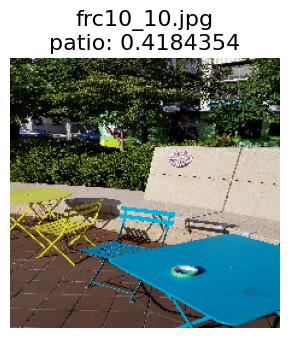

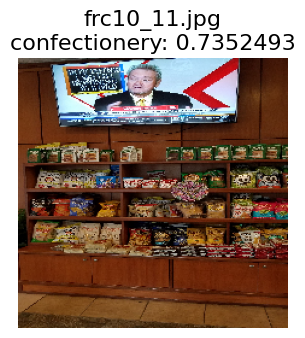

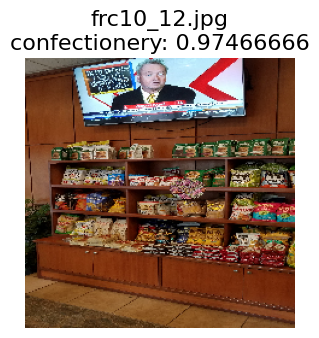

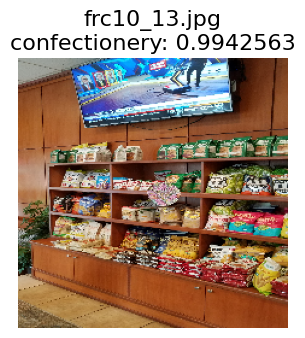

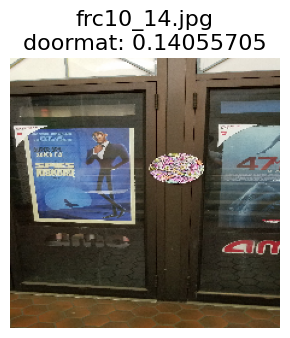

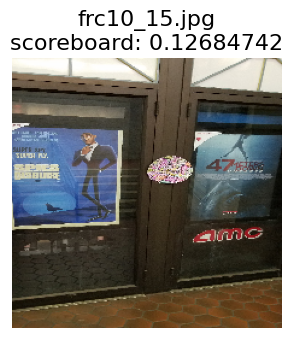

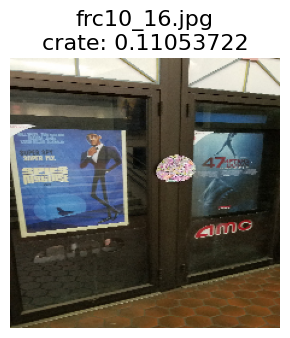

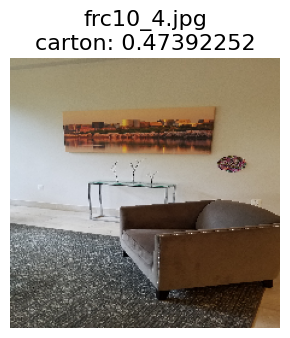

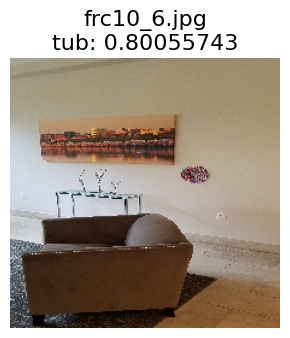

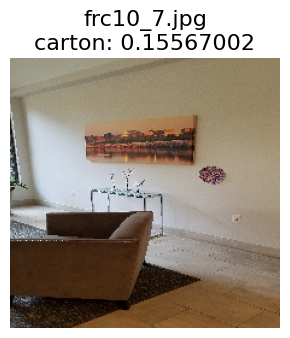

In [9]:
# Load image dataset and convert them to a Numpy array

x = []

for i, file in enumerate(os.listdir()):
    if file.endswith('.jpg'):
        img = load_img(file, target_size=(224, 224))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)

        # Preparing input data for VGG16
        x.append(img.copy())

        tmp_img = preprocess_input(img.copy())
        img_pred = model.predict(tmp_img)
        prediction = decode_predictions(img_pred, top=1)
        prediction

    #     class_lbl = classlabel.index(prediction[0][0][1])
    #     print(prediction, class_lbl)

        # Rendering
        plt.figure(figsize=(3, 4))
        plt.title(file + '\n' + str(prediction[0][0][1]) + ': ' + str(prediction[0][0][2]), fontsize=16)
        plt.imshow(np.uint8(img[0]))
        plt.axis('off')
        plt.tight_layout()
        if i == 10:
            break

# The image resolution is very large and when donwsampled to 224x224(input for our model), it doesnt recognized the patch, as it lost its adversarial features as well

# ----------------------------------------------------------------------------------------------------------------------

# Imagenet-Patch

# ----------------------------------------------------------------------------------------------------------------------

## Display input image with prediction

In [10]:
img = load_img(, target_size=(224, 224))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)

# Preparing input data for VGG16
x.append(img.copy())

tmp_img = preprocess_input(img.copy())
img_pred = model.predict(tmp_img)
prediction = decode_predictions(img_pred, top=1)
prediction

#     class_lbl = classlabel.index(prediction[0][0][1])
#     print(prediction, class_lbl)

# Rendering
plt.figure(figsize=(3, 4))
plt.title('frc01')
plt.imshow(np.uint8(img[0]))
plt.axis('off')
plt.tight_layout()

SyntaxError: invalid syntax (900242351.py, line 1)

1/1 [==============================] - 0s 129ms/step


([[('n04548362', 'wallet', 0.22680093)]], 893)

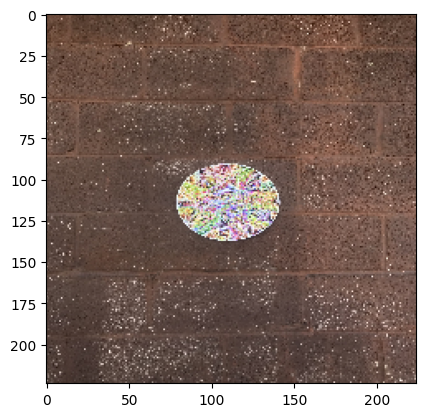

In [112]:
selected_img = x[0]
plt.imshow(np.uint8(selected_img[0]))

tmp_img = selected_img.copy()
tmp_img = preprocess_input(tmp_img)

img_pred = model.predict(tmp_img)
prediction = decode_predictions(img_pred, top=1)
class_lbl = classlabel.index(prediction[0][0][1])
prediction, class_lbl

## Preparing Gradcam function

#### When the softmax activation function is applied to the last layer of model, it may obstruct generating the attention images, so you should replace the function to a linear activation function.

In [111]:
replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

#### And then, you MUST create Score instance or define score function that returns target scores. Here, they return the score values corresponding Goldfish, Bear, Assault Rifle.

In [113]:
# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore(class_lbl)

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][1], output[1][294], output[2][413])

# GradCAM

#### Saliency is one of useful way of visualizing attention that appears the regions of the input image that contributes the most to the output value. GradCAM is another way of visualizing attention over input. Instead of using gradients of model outputs, it uses of penultimate layer output (that is the convolutional layer just before Dense layers).

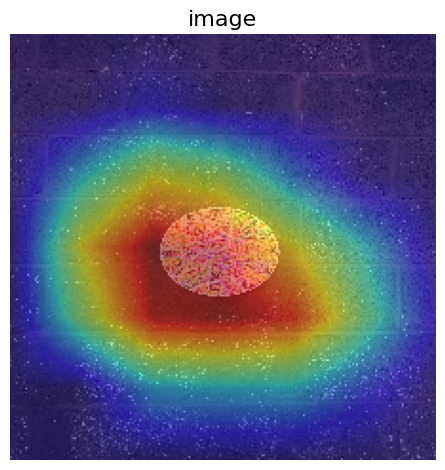

In [114]:
image_titles = ['image']
# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              x[0].copy(),
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    plt.title(title, fontsize=16)
    plt.imshow(np.uint8(x[0][0]))
    plt.imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    plt.axis('off')
    plt.tight_layout()

In [115]:
tmp_heatmap = heatmap.copy()

In [116]:
img_tmp = x[0] / 255.

(-0.5, 223.5, 223.5, -0.5)

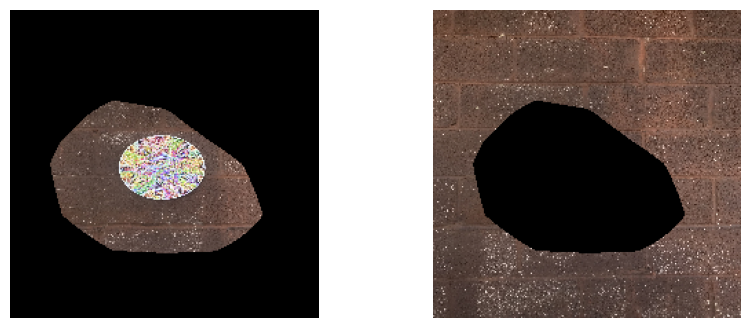

In [117]:
patch_mask = cam[i].copy()
# plt.imshow(img_tmp[0])
# plt.imshow(xx, cmap='gray')

patch_mask[np.where(patch_mask > 0.5)] = 1.
patch_mask[np.where(patch_mask <= 0.5)] = 0.

image_mask = np.where(patch_mask==1., 0., 1.)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

r = np.multiply(patch_mask, img_tmp[0, :, :, 0])
g = np.multiply(patch_mask, img_tmp[0, :, :, 1])
b = np.multiply(patch_mask, img_tmp[0, :, :, 2])
rgb_patch = np.dstack((r,g,b))

axes[0].imshow(rgb_patch)
axes[0].axis('off')

r = np.multiply(image_mask, img_tmp[0, :, :, 0])
g = np.multiply(image_mask, img_tmp[0, :, :, 1])
b = np.multiply(image_mask, img_tmp[0, :, :, 2])
rgb_image = np.dstack((r,g,b))

axes[1].imshow(rgb_image)
axes[1].axis('off')

In [118]:
# # Filter 1
# kernel = np.ones((5,5),np.float32)/25

# blr1 = cv.filter2D(rgb_patch,-1,kernel)

# plt.imshow(blr1)

In [119]:
# # Filter 2
# blr2 = cv.blur(rgb_patch,(5,5))

# plt.imshow(blr2)

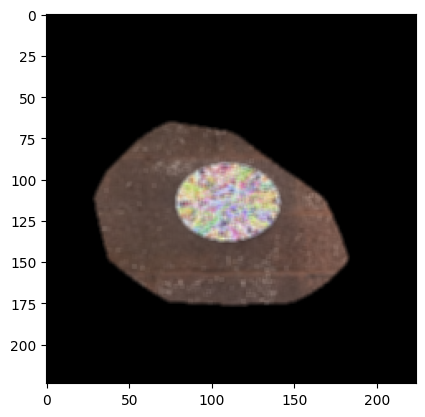

In [120]:
# Gaussian Blur
blur = cv.GaussianBlur(rgb_patch.copy(), (3,3), 10)

# # Median Blue
# blur = cv.medianBlur(rgb_patch.copy(),5)


plt.imshow(blur)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

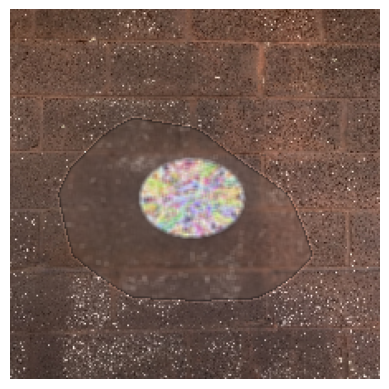

In [121]:
blur_img = blur.copy() + rgb_image.copy()
plt.imshow(blur_img)
plt.axis('off')

In [122]:
new_x = np.expand_dims(blur_img.copy(), axis=0)

# Preparing input data for VGG16
inp_x = preprocess_input(new_x.copy())

blur_img_pred = model.predict(inp_x.copy())
blur_pred = decode_predictions(blur_img_pred, top=1)
blur_pred

blur_class_lbl = classlabel.index(blur_pred[0][0][1])
blur_pred, blur_class_lbl

1/1 [==============================] - 0s 172ms/step


([[('n06359193', 'web_site', 0.07027619)]], 916)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


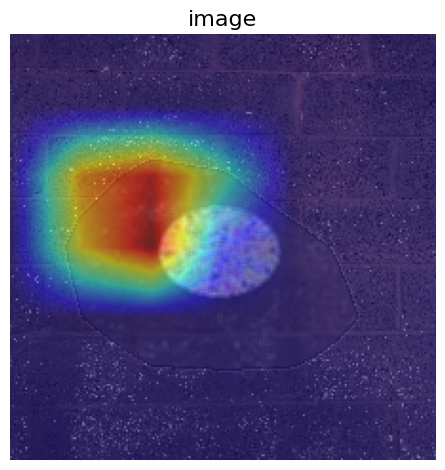

In [123]:
# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              inp_x.copy(),
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    plt.title(title, fontsize=16)
    plt.imshow(new_x[0])
    plt.imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    plt.axis('off')
    plt.tight_layout()

In [ ]:
# manjunah sir
# # take the values in the salience region and fill in the patch region with it

# # color characterstics- usually done by pdf, cdf

# # adversarial training for training

# shruti maam

# guided gradcam
# filters - gaussian, etc